# Домашнее задание "Случайные марковские процессы"
## Задание 1
Скачайте текст войны и мир. Очистите его, оставив только русские буквы и символы пробела.   
Постройте матрицу переходных вероятностей.   
Посчитайте вероятность встретить строку из 4-х символов, которая начинается п, а кончается на р;   
Используя матрицу переходных вероятностей сгенерируйте слово, начинающееся с буквы “Б” и имеющее длину 8-мь символов

In [1]:
# Импортируем библиотеки
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
sns.set()
from hmmlearn.hmm import GaussianHMM
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import boxcox

In [2]:
# Открываем и записываем первый том. И очищаем текст, оставляя только русские буквы и пробелы
with open('tom_1.txt', 'r',  encoding='utf-8') as f:
    text_1 = f.read().lower()
text_1 = re.sub('[^а-я ]','', text_1)

In [3]:
# Аналогично делаем для трёх других томов
with open('tom_2.txt', 'r',  encoding='utf-8') as f:
    text_2 = f.read().lower()
text_2 = re.sub('[^а-я ]','', text_2)

with open('tom_3.txt', 'r',  encoding='utf-8') as f:
    text_3 = f.read().lower()
text_3 = re.sub('[^а-я ]','', text_3)

with open('tom_4.txt', 'r',  encoding='utf-8') as f:
    text_4 = f.read().lower()
text_4 = re.sub('[^а-я ]','', text_4)

In [4]:
# Объединяем тома
text = text_1 + text_2 + text_3 + text_4

In [5]:
# Создаем словарь с возможными событиями
language_dict = 'абвгдежзийклмнопрстуфхцчшщъыьэюя '
POS = {l: i for i, l in enumerate(language_dict)}

In [6]:
# Создам квадратную нулевую матрицу размерностью созданного словаря
probabilities = np.zeros((len(language_dict), len(language_dict)))

In [7]:
# Совмещаем текст с текстом сдвинутым на один символ и считаем сколько раз появилось сочетание каждой пары символов
for cp, cn in zip(text[:-1], text[1:]):
    probabilities[POS[cp], POS[cn]] += 1

In [8]:
# Находим частоту (вероятность перехода) появления сочетаний каждой пары символов
probabilities = (probabilities / probabilities.sum(axis=1)[:, None])

In [9]:
# Сохраняем полученные значения в датафрейм
df = pd.DataFrame(probabilities, index=(c for c in language_dict), columns=(c for c in language_dict))

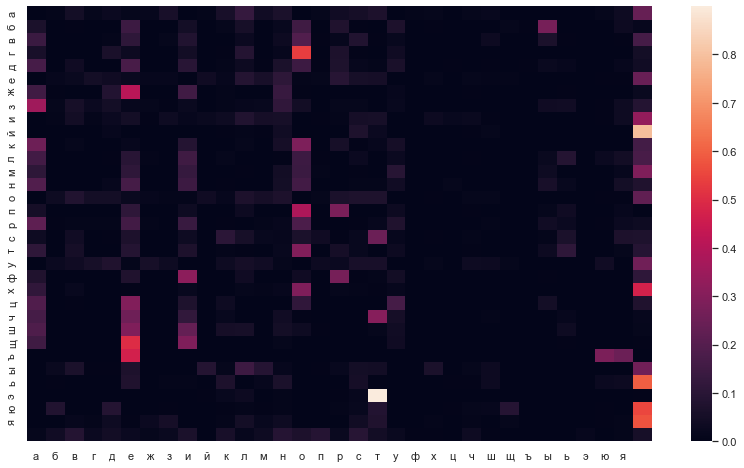

In [10]:
# Визуализируем полученные вероятности
plt.figure(figsize=(14,8))
sns.heatmap(df)
plt.show()

Из полученных значений видим, что наибольшая вероятность получить после буквы "э" букву "т".

In [11]:
# Определим вероятность встретить строку из 4-х символов, которая начинается "п", а кончается на "р"
start = POS['п']
end = POS['р']
prior = 1. / len(language_dict)
proba = 0
for i in language_dict:
    for j in language_dict:
        proba += prior * probabilities[start, POS[i]] * probabilities[POS[i], POS[j]] * probabilities[POS[j], end]
print('Вероятность встретить строку из 4-х символов, которая начинается "п", а кончается на "р" равна', proba)

Вероятность встретить строку из 4-х символов, которая начинается "п", а кончается на "р" равна 0.0009779681063459857


In [12]:
# Сгенерируем слово, начинающееся с буквы “б” и имеющее длину 8-мь символов
s = []
s.append('б')
length = 7
for i in range(length):
    index = POS[s[i]]
    next_char = np.random.choice(list(language_dict), p=probabilities[index])
    s.append(next_char)
print (''.join(s))

бктыла я


## Задание 2
Выберите ряд из предыдущих домашних заданий по временным рядам и оцените его через HMM. Попробуйте “построить” (через среднее каждой компоненты) наивный прогноз ряда.

In [13]:
# Загружаем временной ряд
series = pd.read_csv('international-airline-passengers.csv')['Count']

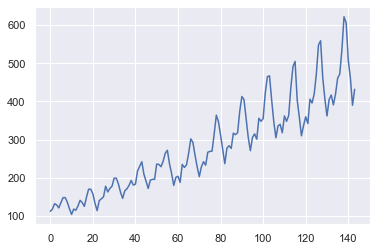

In [14]:
# Строим график
plt.plot(series)
plt.show()

Временной ряд обладает трендом. Для применения HMM требуется исключить тренд из временного ряда.

In [15]:
series = boxcox(series, 0)
series = series[1:] - series[:-1]

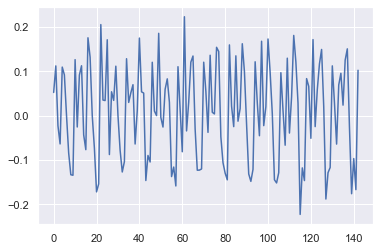

In [16]:
# Строим график
plt.plot(series)
plt.show()

Временной ряд больше не обладает трендом. Можно применять HMM.

In [17]:
values = series.reshape(-1,1)

In [18]:
# Обучае марковскую модель для разного числа компонент
for n in range(1, 14):
    model = GaussianHMM(n_components=n,
                        covariance_type="diag",
                        n_iter=1000)
    model.fit(values)
    print (n, model.score(values))

1 117.7810835338111
2 140.51643468802493
3 168.0809500250114
4 199.0557691126692
5 198.97007455221163
6 199.41954228932946
7 219.37547295720776
8 229.06747762654732
9 229.06773614958234
10 229.06751151884234


Fitting a model with 167 free scalar parameters with only 143 data points will result in a degenerate solution.
Fitting a model with 194 free scalar parameters with only 143 data points will result in a degenerate solution.


11 236.2542716620865
12 209.00485902946397
13 228.98556029400842


Чем больше компонент, тем лучше качество модели.

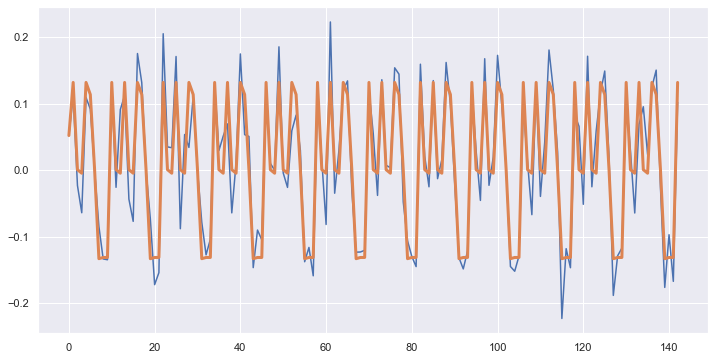

In [19]:
# Визуализируем марковскую модель для 3 компонент
model_3 = GaussianHMM(n_components=3,
                        covariance_type="diag",
                        n_iter=1000)
model_3.fit(values)
labels = model.predict(values)
means = np.zeros_like(values)
for i in range(model.n_components):
    means[labels == i] = model.means_[i]
    
plt.figure(figsize=(12, 6))
plt.plot(values)
plt.plot(means, linewidth=3)

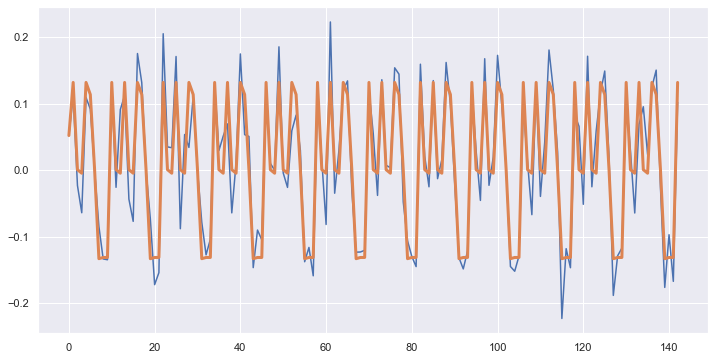

In [20]:
# Визуализируем марковскую модель для 9 компонент
model_9 = GaussianHMM(n_components=3,
                        covariance_type="diag",
                        n_iter=1000)
model_9.fit(values)
labels = model.predict(values)
means = np.zeros_like(values)
for i in range(model.n_components):
    means[labels == i] = model.means_[i]
    
plt.figure(figsize=(12, 6))
plt.plot(values)
plt.plot(means, linewidth=3)

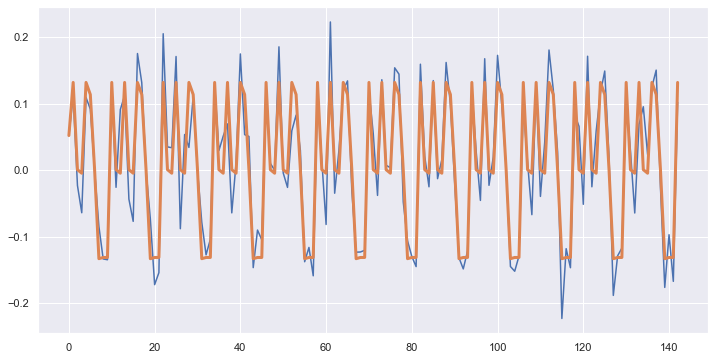

In [21]:
# Визуализируем марковскую модель для 13 компонент
model_13 = GaussianHMM(n_components=3,
                        covariance_type="diag",
                        n_iter=1000)
model_13.fit(values)
labels = model.predict(values)
means = np.zeros_like(values)
for i in range(model.n_components):
    means[labels == i] = model.means_[i]
    
plt.figure(figsize=(12, 6))
plt.plot(values)
plt.plot(means, linewidth=3)

Из полученных результатов видим, что при определенном количестве компонент при увеличении числа компонент качество улучшается незначительно.